## <font color='purple'> Data 255 - Lab 1 - Part 2

<font color='purple'> Train a neural network (21 points) \
    \
a.Decide the number of layers and neurons in each layer (2 points) \
b.Try different number of epochs and batch sizes (2 points) \
c. Try out different activation functions (explain each one you used) (3 points) \
d.Try at least three different regularizations (3 points) \
e.Try different loss functions (3 points) \
f. Try different optimization algorithms (such as Gradient Descent, Adam, etc.) (4 points) \
g. Decide your best-performing model based on both time and accuracy. (1 point) \
h. Create a graph of loss vs epochs for training and testing set. (1 point) \
i.Create a graph of f1 score vs epochs for training and testing set. (1 point) \
j.Calculate the number of trainable parameters in your final model

In [1]:
import os
import time
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

<font color='blue'> Define Transformations \
Define the transformations for the training and validation datasets. These include resizing, normalization, and data augmentation.

<font color='blue'> Load Dataset - Load the dataset using ImageFolder \
    \
    <b>Note:</b> I used Kaggle for training, So I simply used the Kaggle dataset and loaded in the session as an input

In [2]:
data_dir = '/kaggle/input/sports-image-classification/dataset'
train_csv_path = os.path.join(data_dir, 'train.csv')
test_csv_path = os.path.join(data_dir, 'test.csv')
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)

total_train_images_in_csv = len(train_data)

total_test_images_in_csv = len(test_data)

all_train_images_in_folder = os.listdir(train_img_dir)
train_image_extensions = ['.jpg', '.jpeg', '.png']
train_images_in_folder = [img for img in all_train_images_in_folder if os.path.splitext(img)[1].lower() in train_image_extensions]
total_train_images_in_folder = len(train_images_in_folder)

all_test_images_in_folder = os.listdir(test_img_dir)
test_image_extensions = ['.jpg', '.jpeg', '.png']
test_images_in_folder = [img for img in all_test_images_in_folder if os.path.splitext(img)[1].lower() in test_image_extensions]
total_test_images_in_folder = len(test_images_in_folder)

num_train_classes = train_data['label'].nunique()

print(f"Training set: ")
print(f" - Total number of images in train.csv: {total_train_images_in_csv}")
print(f" - Total number of images in the training folder: {total_train_images_in_folder}")
print(f" - Number of unique classes in training set: {num_train_classes}")

print(f"\nTesting set: ")
print(f" - Total number of images in test.csv: {total_test_images_in_csv}")
print(f" - Total number of images in the testing folder: {total_test_images_in_folder}")
print(f" - Number of unique classes in testing set: 0")

print('\nNumber of Images per class')
print(train_data['label'].value_counts())

Training set: 
 - Total number of images in train.csv: 8227
 - Total number of images in the training folder: 8227
 - Number of unique classes in training set: 7

Testing set: 
 - Total number of images in test.csv: 2056
 - Total number of images in the testing folder: 2056
 - Number of unique classes in testing set: 0

Number of Images per class
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


<font color='blue'> Print Class Names and print number of pixels for the first two images for each class

In [3]:
class_pixel_dimensions = {}

for label in train_data['label'].unique():
    image_ids = train_data[train_data['label'] == label]['image_ID'].head(2).tolist()

    dimensions = []
    
    for image_id in image_ids:
        img_path = os.path.join(train_img_dir, image_id)
        if os.path.exists(img_path):
            with Image.open(img_path) as img:
                width, height = img.size
                dimensions.append((width, height))
    
    class_pixel_dimensions[label] = dimensions

print("Number of pixels (width, height) in the first 2 images of each class:")
for label, dims in class_pixel_dimensions.items():
    print(f"{label}: {dims}")

Number of pixels (width, height) in the first 2 images of each class:
Badminton: [(380, 285), (268, 172)]
Cricket: [(1200, 900), (2048, 1152)]
Tennis: [(299, 168), (300, 168)]
Swimming: [(259, 194), (1280, 720)]
Soccer: [(300, 168), (268, 188)]
Wrestling: [(1400, 788), (1024, 576)]
Karate: [(300, 168), (275, 183)]


<font color='blue'> Plot samples images for each Class. I have printed 3 images from each Class

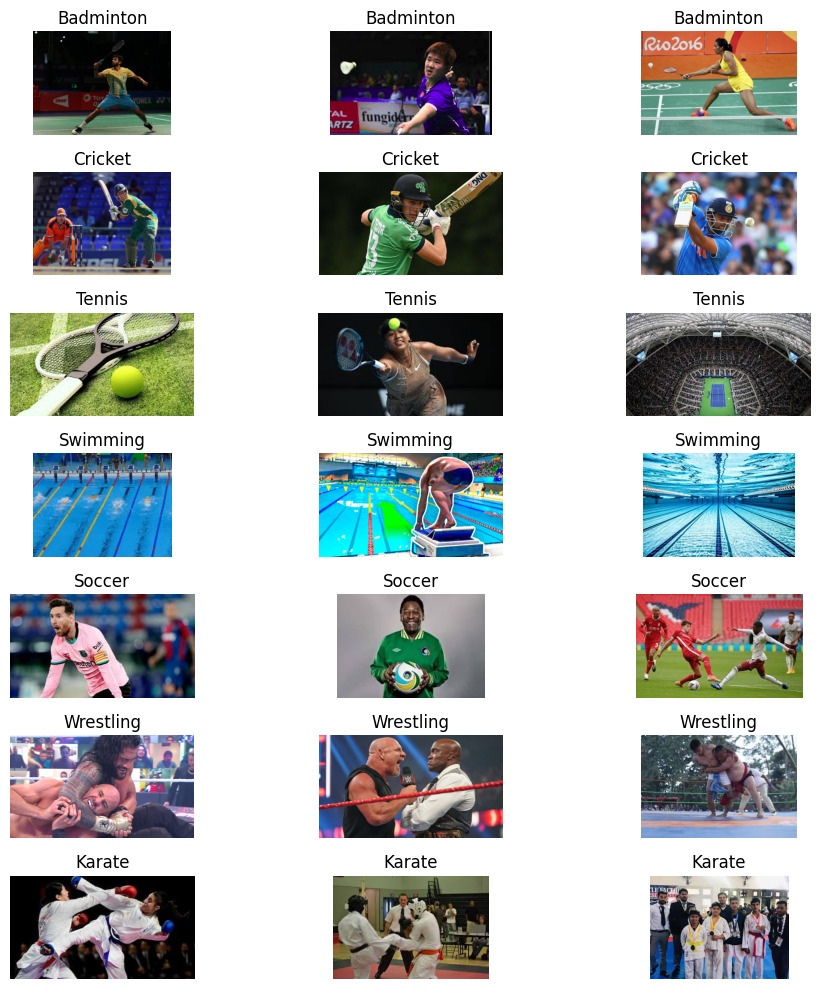

In [4]:
num_images_to_display = 3

unique_classes = train_data['label'].unique()

plt.figure(figsize=(10, 10))
subplot_index = 1

for label in unique_classes:
    image_ids = train_data[train_data['label'] == label]['image_ID'].head(num_images_to_display).tolist()
    
    for image_id in image_ids:
        img_path = os.path.join(train_img_dir, image_id)
        if os.path.exists(img_path):
            img = Image.open(img_path)
            plt.subplot(len(unique_classes), num_images_to_display, subplot_index)
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
            
            subplot_index += 1
            
plt.tight_layout()
plt.show()

<font color='blue'> Create Dataset class to be used to create our Dataset for feeding to dataloaders

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform
        
        self.class_names = self.dataframe['label'].unique()
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0].strip())
        image = Image.open(img_name).convert("RGB")
        label = self.dataframe.iloc[idx, 1].strip()
        
        label_idx = self.class_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

<font color='blue'> Setup Data Augmentation methods for Training and Validation Sets

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

<font color='blue'> Create the dataset using the custom class and the image directory structure

In [7]:
dataset = CustomImageDataset(csv_file=train_csv_path, img_dir=train_img_dir, transform=train_transforms)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = val_transforms

<font color='blue'> Function to print sizes of the generated dataloaders

In [8]:
def print_loader_sizes(data_loader, loader_name):
    total_batches = len(data_loader)
    total_samples = len(data_loader.dataset)

    print(f"{loader_name} - Total Samples: {total_samples}, Total Batches: {total_batches}")

<font color='blue'> Function to display Image

In [9]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

<font color='blue'> Function to show images from the dataloader

In [10]:
def show_images_from_loader(data_loader, num_images=6):
    images, labels = next(iter(data_loader))
    images = images[:num_images]
    labels = labels[:num_images]

    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        title = unique_classes[labels[i].item()]
        imshow(images[i], title=title)
    plt.show()

<font color='blue'> Function to create dataloaders for the given batch sizes

In [11]:
def create_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    print_loader_sizes(train_loader, "Train Loader")
    print("Train Loader Images:")
    show_images_from_loader(train_loader)
    
    print_loader_sizes(val_loader, "Validation Loader")
    print("Validation Loader Images:")
    show_images_from_loader(val_loader)
    
    return train_loader, val_loader

<font color='blue'> Create Dataloaders for Test and Validate Sets and print a few sample Images

Train Loader - Total Samples: 6581, Total Batches: 206
Train Loader Images:


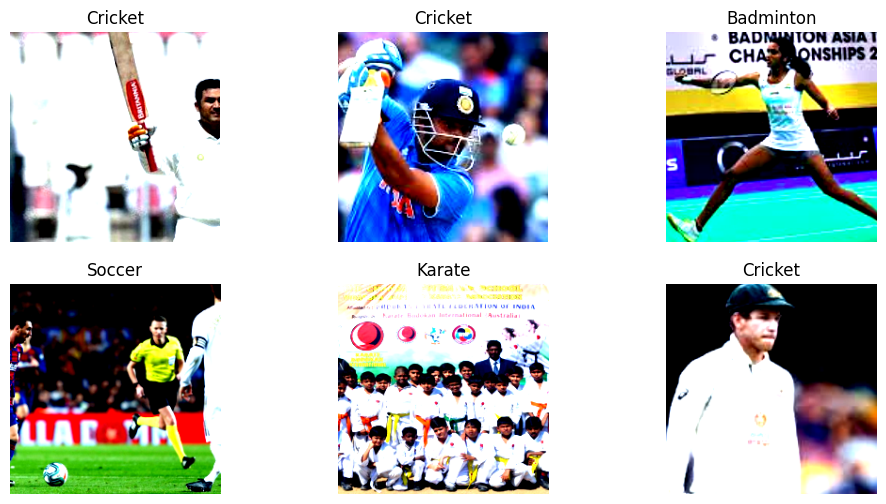

Validation Loader - Total Samples: 1646, Total Batches: 52
Validation Loader Images:


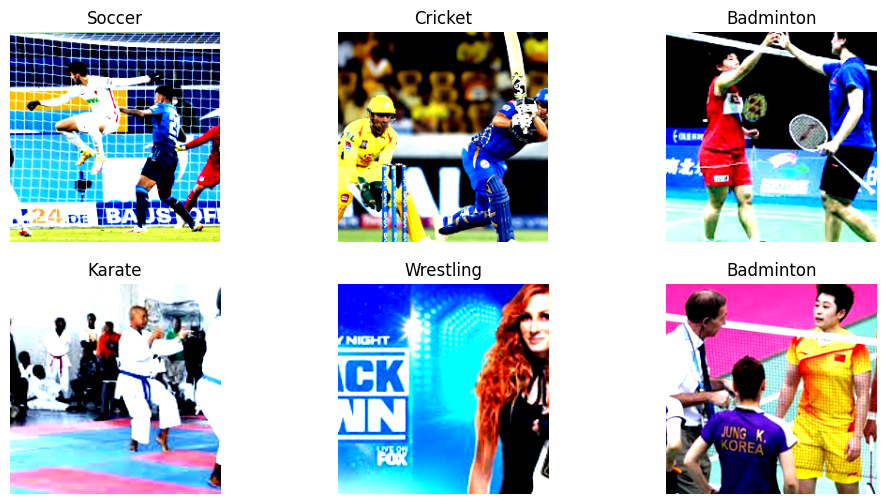

In [12]:
train_loader, val_loader = create_loaders(32)

### <font color='blue'> Train a neural network (21 points)

<font color='blue'> Setup the Device, Use CUDA if GPU is available, else use CPU

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


<font color='blue'> Setup the Model Architecture \
    \
<b> 4 Convolution Layers (3,32) (32, 64) (64, 128) (128, 256) \
3 Fully Connected Layers (128 * 28 * 28, 256) (512, 256) (256, 7) \
    1 Pooling Layer \
    1 Drop Layer</b> 

In [14]:
class SportsCNN(nn.Module):
    def __init__(self):
        super(SportsCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

<font color='blue'> Setup the Model Evaluation Loop. \
    <b>Expected output variables Validation Loss, Accuracy, Confusion Matrix and Report</b>

In [15]:
def evaluate_model(model, data_loader, device, class_names, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad(): 
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    avg_val_loss = running_val_loss / len(data_loader)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names)
    return avg_val_loss, accuracy, cm, report

<font color='blue'> Setup the Train Evaluation Loop. \
    <b>Expected output variables: Training and Validation Losses along with the last Epoch Number based on Early Stopping.</b>

In [21]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5):
    
    print(f"Start Training: Epochs: {num_epochs}")
    print('-----------------------------')
    num_epochs = num_epochs
    train_losses = [] 
    val_losses = []
    stopping_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)

        val_loss, accuracy, cm, report = evaluate_model(model, val_loader, device, unique_classes, criterion)
        val_losses.append(val_loss)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                stopping_epoch = epoch
                break
        
        print(f'Epoch {epoch+1}/{num_epochs}, \
                Training Loss: {average_loss:.4f}, \
                Validation Loss: {val_loss:.4f}, \
                Accuracy: {accuracy * 100:.2f}%, \
                Epoch Time: {epoch_duration:.2f} seconds')
    
    total_training_time = time.time() - start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')
    
    print('-----------------------------')  
    print('End Training')
    return train_losses, val_losses, stopping_epoch

<font color='blue'> Plot Losses vs Epochs

In [12]:
def plot_epoch_losses(num_epochs, train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

<font color='blue'> Define the Training Loop to be reused across different Models

In [29]:
def train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience):
    train_losses, val_losses, stopping_epoch = train_model(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)
    if stopping_epoch != 0:
        num_epochs = stopping_epoch
    plot_epoch_losses(num_epochs, train_losses[:num_epochs], val_losses[:num_epochs])
    final_val_loss, final_accuracy, final_cm, final_report = evaluate_model(model, val_loader, device, unique_classes, criterion)
    print("===============================================")
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final Accuracy: {final_accuracy * 100:.2f}%')
    print("Confusion Matrix:")
    print(final_cm)
    print("Classification Report:")
    print(final_report)

### <font color='blue'> <b> Setup 1: Baseline Model </b>
<font color='darkgreen'> \
<b>Epochs:</b> 10\
<b>Batch Size:</b> 32\
<b>Optimizer:</b> Adam\
<b>Loss Function:</b> Cross Entropy Loss\
<b>Regularization:</b> Drop-Out(0.5)\
<b>Early-stopping criteria</b>

Training for Base Model: Epochs: 10 Batch Size: 32 Optimizer: Adam Loss Function: Cross Entropy Loss 
Start Training: Epochs: 10
-----------------------------
Epoch 1/10,                 Training Loss: 1.6143,                 Validation Loss: 1.2878,                 Accuracy: 50.24%,                 Epoch Time: 47.76 seconds
Epoch 2/10,                 Training Loss: 1.2504,                 Validation Loss: 1.0789,                 Accuracy: 59.96%,                 Epoch Time: 46.70 seconds
Epoch 3/10,                 Training Loss: 1.0859,                 Validation Loss: 0.9482,                 Accuracy: 65.13%,                 Epoch Time: 46.27 seconds
Epoch 4/10,                 Training Loss: 0.9884,                 Validation Loss: 0.9288,                 Accuracy: 66.04%,                 Epoch Time: 45.78 seconds
Epoch 5/10,                 Training Loss: 0.9049,                 Validation Loss: 0.8516,                 Accuracy: 69.81%,                 Epoch Time: 45.07 seconds
E

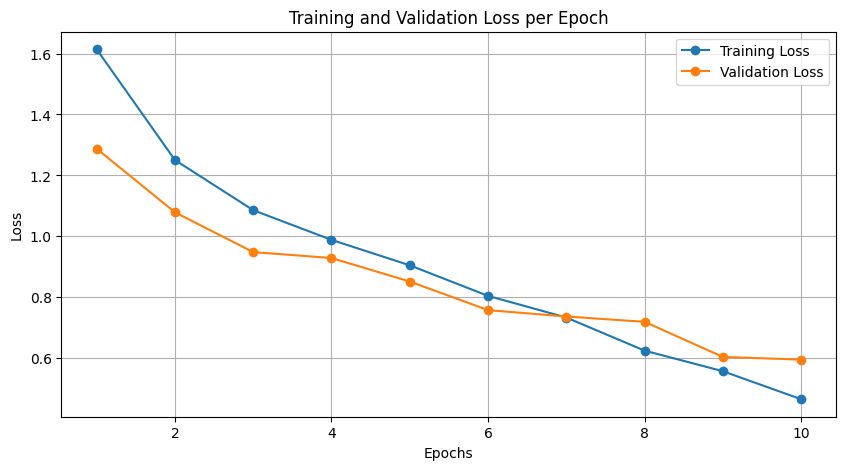

Final Validation Loss: 0.5952
Final Accuracy: 81.53%
Confusion Matrix:
[[233  17  10   2   3  10   6]
 [  4 258  15   1  11   2   4]
 [ 17  23 210   7   9   7   7]
 [  3   3   7 107   0   1   0]
 [  7  32  23   0 162   4   5]
 [ 12   9   3   8   2 288   5]
 [  2  14   4   0   3   2  84]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.84      0.83      0.83       281
     Cricket       0.72      0.87      0.79       295
      Tennis       0.77      0.75      0.76       280
    Swimming       0.86      0.88      0.87       121
      Soccer       0.85      0.70      0.77       233
   Wrestling       0.92      0.88      0.90       327
      Karate       0.76      0.77      0.76       109

    accuracy                           0.82      1646
   macro avg       0.82      0.81      0.81      1646
weighted avg       0.82      0.82      0.82      1646



In [25]:
model = SportsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 10
print('Training for Base Model: Epochs: 10 Batch Size: 32 Optimizer: Adam Loss Function: Cross Entropy Loss ')
train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [26]:
torch.save(model, 'base_model.pth')

### <font color='blue'> <b> Setup 2: Higher Batch Size, Epoch Increase and Weight Decay </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Cross Entropy Loss \
<b>Regularization:</b> Drop-Out(0.5) & Weight Decay \
<b>Early-stopping criteria</b>

Train Loader - Total Samples: 6581, Total Batches: 103
Train Loader Images:


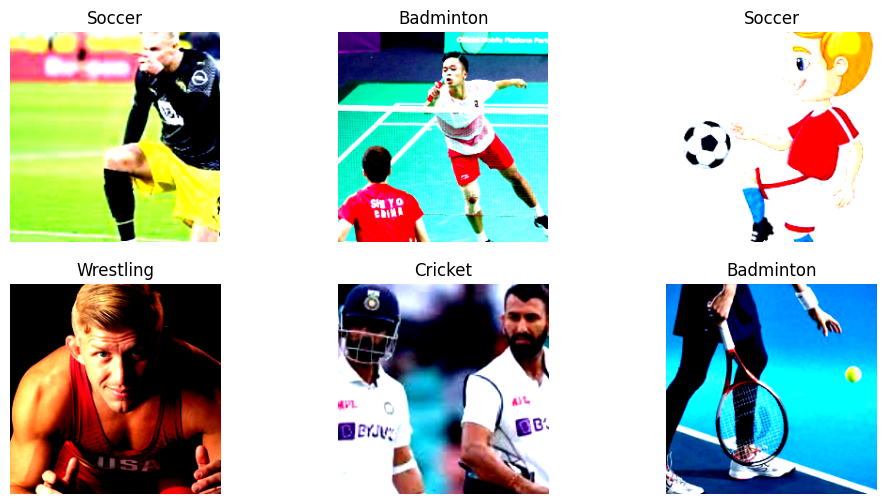

Validation Loader - Total Samples: 1646, Total Batches: 26
Validation Loader Images:


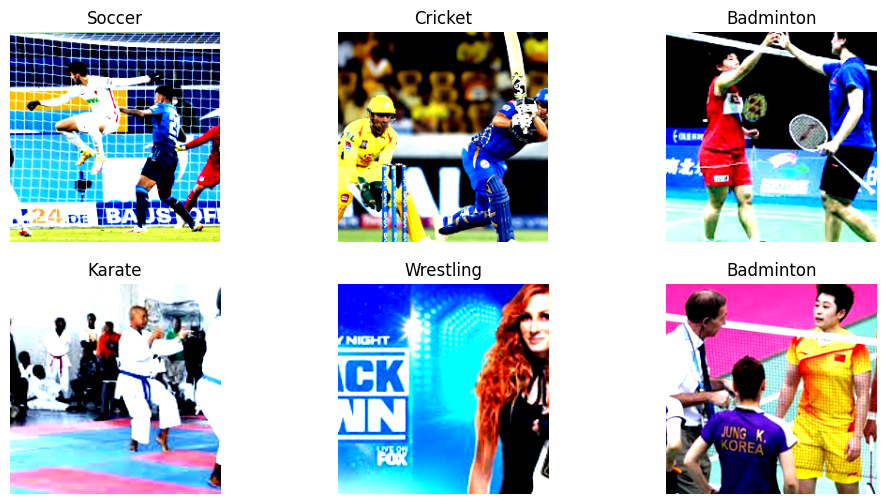

In [27]:
train_loader, val_loader = create_loaders(64)

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.6534,                 Validation Loss: 1.2930,                 Accuracy: 52.25%,                 Epoch Time: 45.34 seconds
Epoch 2/20,                 Training Loss: 1.2849,                 Validation Loss: 1.1487,                 Accuracy: 58.44%,                 Epoch Time: 44.38 seconds
Epoch 3/20,                 Training Loss: 1.1475,                 Validation Loss: 1.0609,                 Accuracy: 61.48%,                 Epoch Time: 44.63 seconds
Epoch 4/20,                 Training Loss: 1.0673,                 Validation Loss: 1.0085,                 Accuracy: 63.97%,                 Epoch Time: 47.87 seconds
Epoch 5/20,                 Training Loss: 0.9881,                 Validation Loss: 0.9395,                 Accuracy: 66.46%,                 Epoch Time: 45.44 seconds
Epoch 6/20,                 Training Loss: 0.9229,                 Validation Loss: 0.9348,            

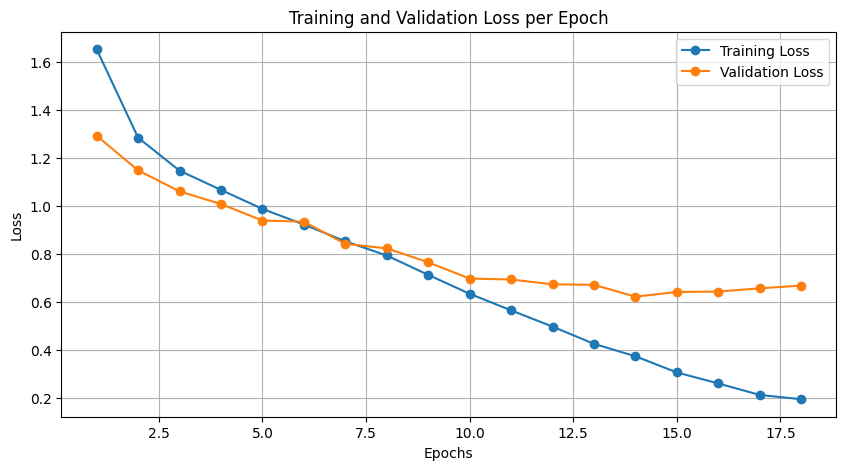

Final Validation Loss: 0.7080
Final Accuracy: 83.84%
Confusion Matrix:
[[240   7  16   2   6   6   4]
 [  4 228  13   0  28   6  16]
 [  4  11 230   6  12   5  12]
 [  4   0   6 108   0   2   1]
 [  2  14  14   0 190   5   8]
 [  8   1   6   4   4 297   7]
 [  1   4  11   2   4   0  87]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.91      0.85      0.88       281
     Cricket       0.86      0.77      0.81       295
      Tennis       0.78      0.82      0.80       280
    Swimming       0.89      0.89      0.89       121
      Soccer       0.78      0.82      0.80       233
   Wrestling       0.93      0.91      0.92       327
      Karate       0.64      0.80      0.71       109

    accuracy                           0.84      1646
   macro avg       0.83      0.84      0.83      1646
weighted avg       0.84      0.84      0.84      1646



In [31]:
model = SportsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20
train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [32]:
torch.save(model, 'model1_64_20_L2.pth')

### <font color='blue'> <b> Setup 3: Higher Batch Size, Epoch Increase and Optimizer Change </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 128 (Increased) \
<b>Optimizer:</b> RMSProp \
<b>Loss Function:</b> Cross Entropy Loss \
<b>Regularization:</b> Weight Decay \
<b>Early-stopping criteria</b>

Train Loader - Total Samples: 6581, Total Batches: 52
Train Loader Images:


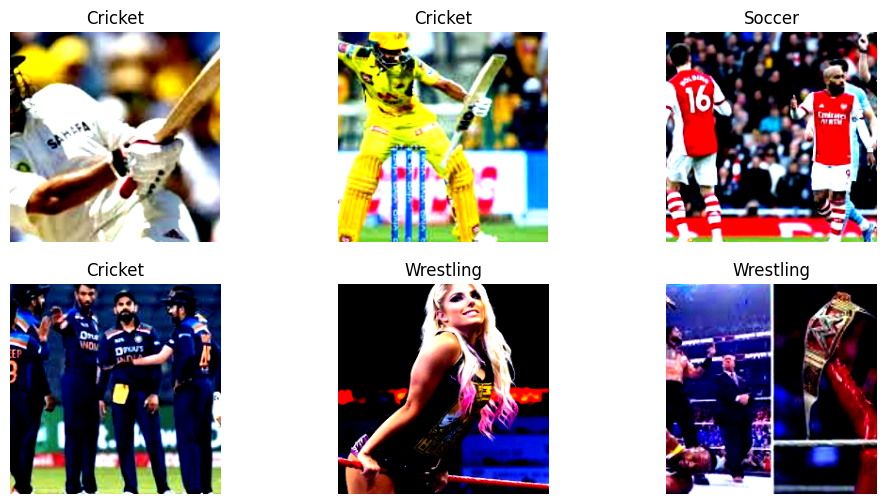

Validation Loader - Total Samples: 1646, Total Batches: 13
Validation Loader Images:


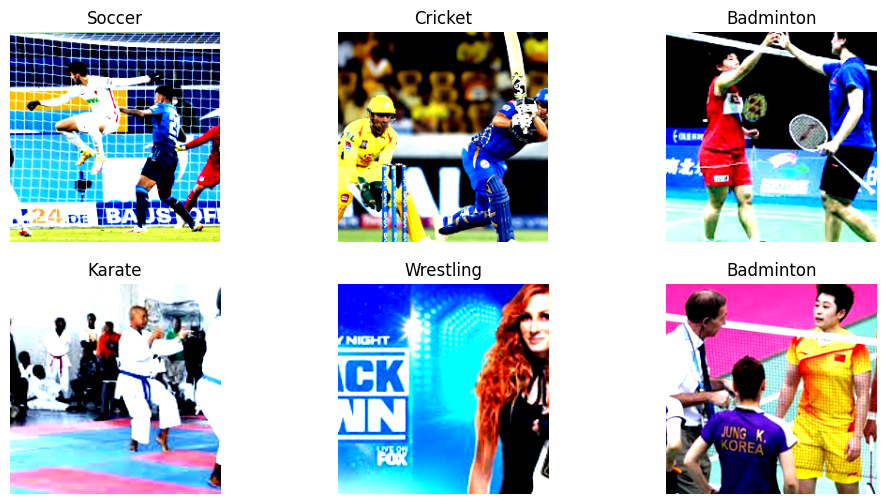

In [33]:
train_loader, val_loader = create_loaders(128)

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.6696,                 Validation Loss: 1.3721,                 Accuracy: 46.11%,                 Epoch Time: 46.88 seconds
Epoch 2/20,                 Training Loss: 1.3186,                 Validation Loss: 1.2380,                 Accuracy: 55.77%,                 Epoch Time: 48.34 seconds
Epoch 3/20,                 Training Loss: 1.2012,                 Validation Loss: 1.1492,                 Accuracy: 57.78%,                 Epoch Time: 45.29 seconds
Epoch 4/20,                 Training Loss: 1.0941,                 Validation Loss: 1.1061,                 Accuracy: 59.42%,                 Epoch Time: 44.59 seconds
Epoch 5/20,                 Training Loss: 1.0293,                 Validation Loss: 1.0045,                 Accuracy: 64.40%,                 Epoch Time: 44.29 seconds
Epoch 6/20,                 Training Loss: 0.9644,                 Validation Loss: 1.0075,            

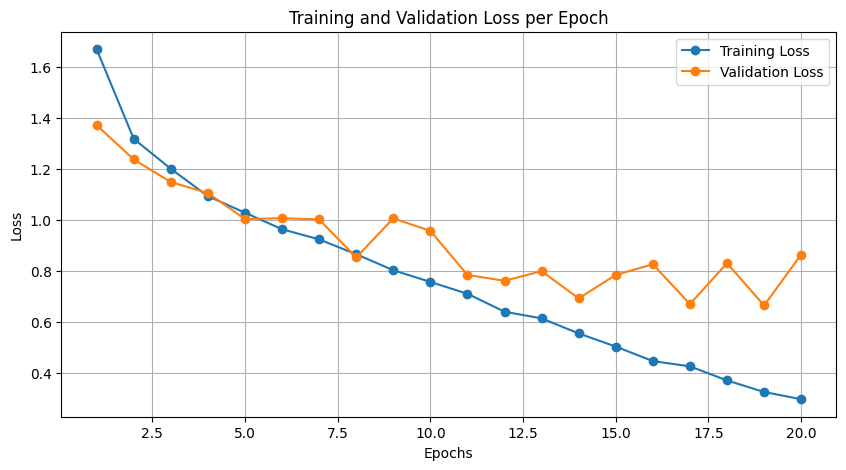

Final Validation Loss: 0.8651
Final Accuracy: 72.90%
Confusion Matrix:
[[177   7  66   1  23   4   3]
 [  3 209  40   0  37   0   6]
 [  3  10 237   4  20   1   5]
 [  2   1  14 102   2   0   0]
 [  1   6  19   0 200   3   4]
 [ 22   7  84   4   7 202   1]
 [  2   6  16   3   6   3  73]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.84      0.63      0.72       281
     Cricket       0.85      0.71      0.77       295
      Tennis       0.50      0.85      0.63       280
    Swimming       0.89      0.84      0.87       121
      Soccer       0.68      0.86      0.76       233
   Wrestling       0.95      0.62      0.75       327
      Karate       0.79      0.67      0.73       109

    accuracy                           0.73      1646
   macro avg       0.79      0.74      0.75      1646
weighted avg       0.78      0.73      0.74      1646



In [38]:
model = SportsCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [39]:
torch.save(model, 'model2_128_30_RMSp_L2.pth')

### <font color='blue'> <b> Setup 4: AdamW Optimizer, FocalLoss as loss criterion & Reducing Batch Size  </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 \
<b>Batch Size:</b> 64 \
<b>Optimizer:</b> AdamW \
<b>Loss Function:</b> Focal Loss \
<b>Regularization:</b> Drop-Out(0.5) & Weight Decay \
<b>Early-stopping criteria</b>

Train Loader - Total Samples: 6581, Total Batches: 103
Train Loader Images:


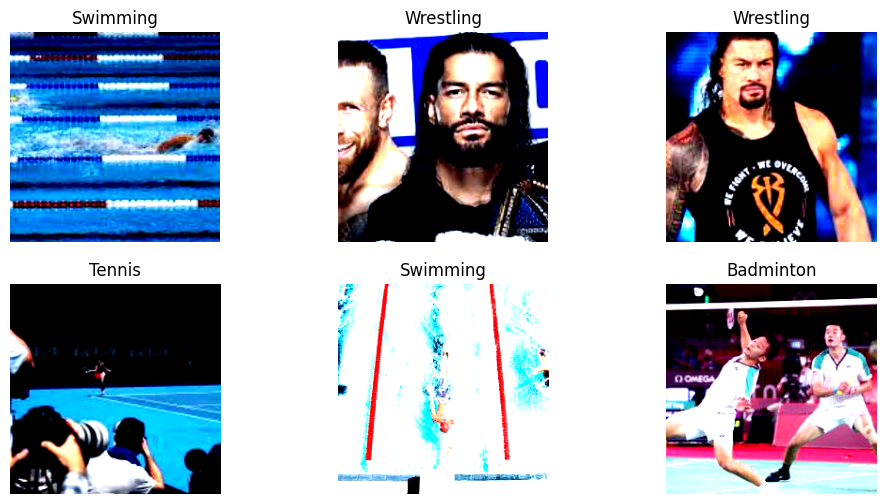

Validation Loader - Total Samples: 1646, Total Batches: 26
Validation Loader Images:


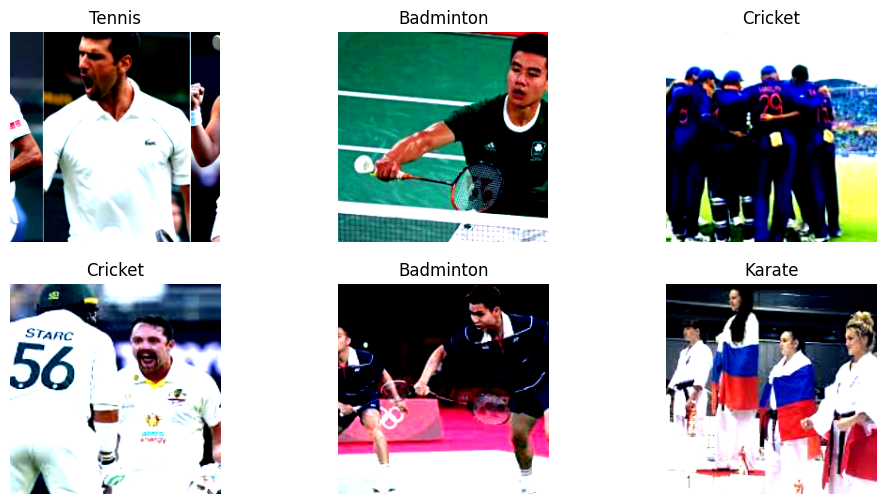

In [13]:
train_loader, val_loader = create_loaders(64)

In [41]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        focal_loss = ((1 - pt) ** self.gamma) * BCE_loss

        if self.alpha is not None:
            alpha = self.alpha[targets]
            focal_loss = alpha * focal_loss

        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        else:
            return focal_loss


Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.1485,                 Validation Loss: 0.8501,                 Accuracy: 48.18%,                 Epoch Time: 48.20 seconds
Epoch 2/20,                 Training Loss: 0.8210,                 Validation Loss: 0.7012,                 Accuracy: 56.08%,                 Epoch Time: 44.17 seconds
Epoch 3/20,                 Training Loss: 0.7055,                 Validation Loss: 0.6263,                 Accuracy: 60.45%,                 Epoch Time: 44.51 seconds
Epoch 4/20,                 Training Loss: 0.6355,                 Validation Loss: 0.5692,                 Accuracy: 64.70%,                 Epoch Time: 44.28 seconds
Epoch 5/20,                 Training Loss: 0.5598,                 Validation Loss: 0.5307,                 Accuracy: 66.34%,                 Epoch Time: 45.06 seconds
Epoch 6/20,                 Training Loss: 0.5077,                 Validation Loss: 0.5140,            

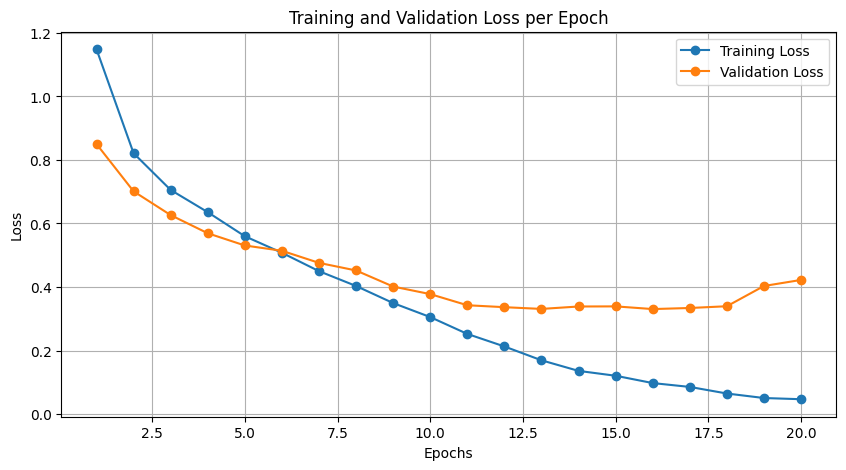

Final Validation Loss: 0.4223
Final Accuracy: 83.66%
Confusion Matrix:
[[249  10   9   1   3   7   2]
 [  6 262   8   1   8   7   3]
 [ 12  26 214  11   7   4   6]
 [  6   1   5 108   0   1   0]
 [  2  34  17   0 171   5   4]
 [ 12   7   4   7   0 295   2]
 [  2  10   5   5   3   6  78]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.86      0.89      0.87       281
     Cricket       0.75      0.89      0.81       295
      Tennis       0.82      0.76      0.79       280
    Swimming       0.81      0.89      0.85       121
      Soccer       0.89      0.73      0.80       233
   Wrestling       0.91      0.90      0.90       327
      Karate       0.82      0.72      0.76       109

    accuracy                           0.84      1646
   macro avg       0.84      0.83      0.83      1646
weighted avg       0.84      0.84      0.84      1646



In [42]:
model = SportsCNN().to(device)
criterion = FocalLoss(gamma=2, alpha=None, reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [43]:
torch.save(model, 'model3_64_20_FL_AdamW_L2.pth')

So far, we see that with optimizer RMSProp, model is not able to learn well. The results are fluctuating. When used loss function "FocalLoss" and with combination of optimizer "AdamW" the performance was still better almost comparable to with Loss function CrossEntropyLoss and optimiser Adam.

Also, I have tried loss function SGD earlier, but the results were really poor in the first epoch itself. So did not go further with SGD.

## <font color='blue'> Changing the model architecture for trying different Activation function and diferent dropouts

### <font color='blue'> <b> Setup 5: LeakyRelu Activation with Label Smoothing Loss and Weight Decay </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Label Smoothing Loss Criterion \
<b>Regularization:</b> Drop-Out(0.5) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>LeakyRelu Activation</b>

In [18]:
class SportsCNN_Leaky(nn.Module):
    def __init__(self):
        super(SportsCNN_Leaky, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv3(x), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.conv4(x), negative_slope=0.01))
        x = x.view(x.size(0), -1)
        
        x = F.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.fc3(x)
        return x

In [19]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, reduction='mean'):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.reduction = reduction

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        if self.reduction == 'mean':
            return torch.mean(torch.sum(-true_dist * pred, dim=-1))
        elif self.reduction == 'sum':
            return torch.sum(torch.sum(-true_dist * pred, dim=-1))
        else:
            return torch.sum(-true_dist * pred, dim=-1)

Train Loader - Total Samples: 6581, Total Batches: 103
Train Loader Images:


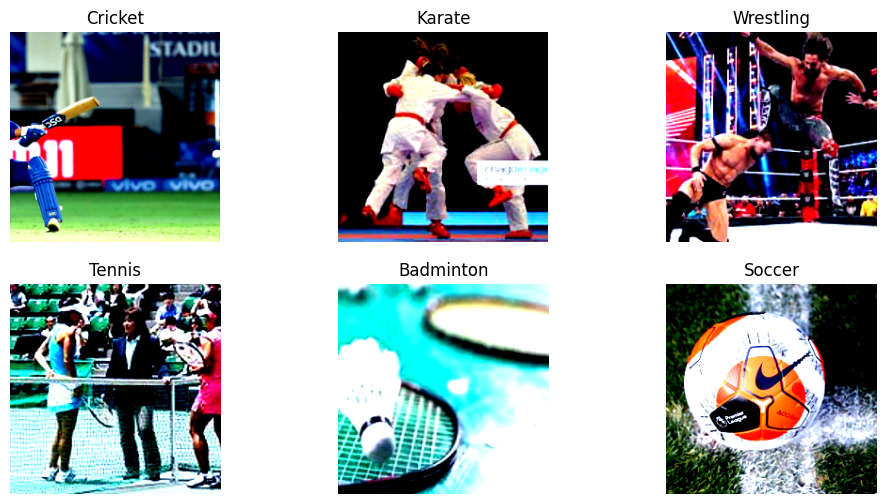

Validation Loader - Total Samples: 1646, Total Batches: 26
Validation Loader Images:


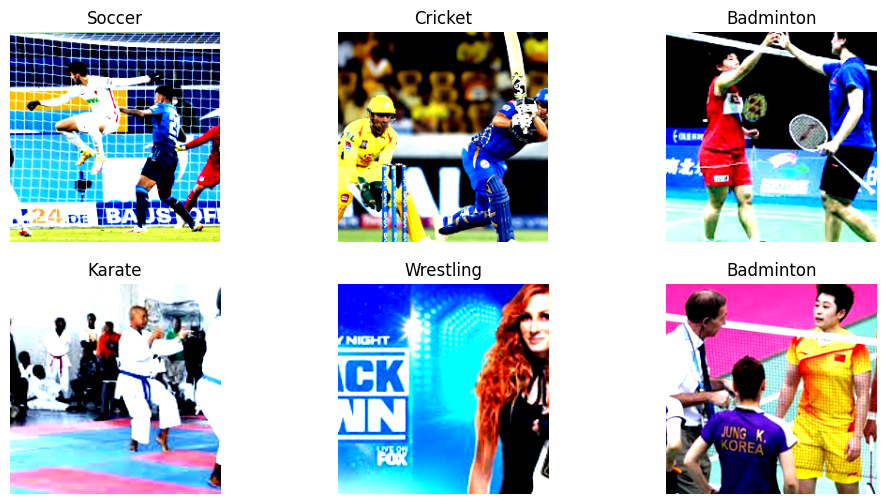

In [46]:
train_loader, val_loader = create_loaders(64)

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.7167,                 Validation Loss: 1.4633,                 Accuracy: 51.76%,                 Epoch Time: 51.52 seconds
Epoch 2/20,                 Training Loss: 1.4175,                 Validation Loss: 1.3054,                 Accuracy: 61.12%,                 Epoch Time: 45.18 seconds
Epoch 3/20,                 Training Loss: 1.2977,                 Validation Loss: 1.2380,                 Accuracy: 63.61%,                 Epoch Time: 45.95 seconds
Epoch 4/20,                 Training Loss: 1.2008,                 Validation Loss: 1.2472,                 Accuracy: 64.40%,                 Epoch Time: 45.02 seconds
Epoch 5/20,                 Training Loss: 1.1378,                 Validation Loss: 1.1099,                 Accuracy: 71.26%,                 Epoch Time: 45.95 seconds
Epoch 6/20,                 Training Loss: 1.0715,                 Validation Loss: 1.0707,            

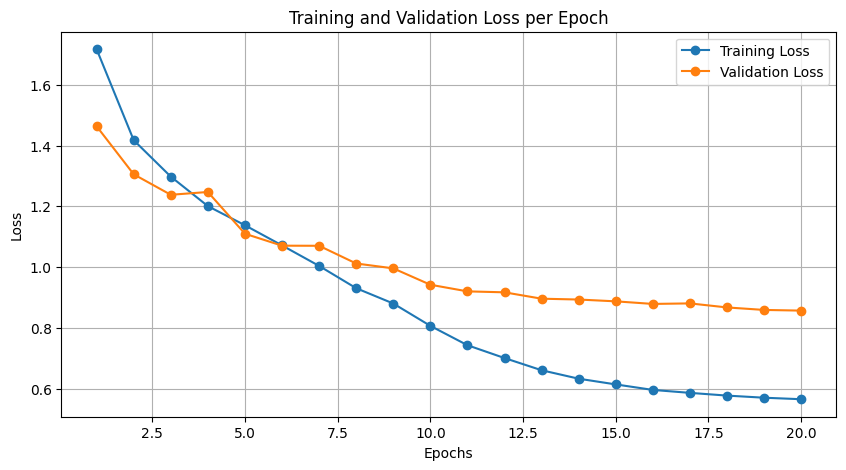

Final Validation Loss: 0.8572
Final Accuracy: 85.91%
Confusion Matrix:
[[241   7  13   1   3  12   4]
 [  4 257  11   1  10   5   7]
 [  6  22 230   4   4   7   7]
 [  3   2   5 109   0   2   0]
 [  2  19  20   1 184   4   3]
 [  7   6   2   5   0 304   3]
 [  2   7   4   0   3   4  89]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.91      0.86      0.88       281
     Cricket       0.80      0.87      0.84       295
      Tennis       0.81      0.82      0.81       280
    Swimming       0.90      0.90      0.90       121
      Soccer       0.90      0.79      0.84       233
   Wrestling       0.90      0.93      0.91       327
      Karate       0.79      0.82      0.80       109

    accuracy                           0.86      1646
   macro avg       0.86      0.86      0.86      1646
weighted avg       0.86      0.86      0.86      1646



In [55]:
model = SportsCNN_Leaky().to(device)
criterion = LabelSmoothingLoss(classes=len(unique_classes), smoothing=0.1, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [56]:
torch.save(model, 'model4_64_20_LS_LRelu_Adam_L2.pth')

### <font color='blue'> <b> Setup 6: ELU Activation with Label Smoothing Loss and Adam Optimizer </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Label Smoothing Loss Criterion \
<b>Regularization:</b> Drop-Out(0.5) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>ELU Activation</b>

In [58]:
class SportsCNN_ELU(nn.Module):
    def __init__(self):
        super(SportsCNN_ELU, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.pool(F.elu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        
        x = F.elu(self.fc1(x))
        x = self.dropout(x)
        x = F.elu(self.fc2(x))
        x = self.fc3(x)
        return x

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.5491,                 Validation Loss: 1.3857,                 Accuracy: 57.65%,                 Epoch Time: 47.29 seconds
Epoch 2/20,                 Training Loss: 1.3076,                 Validation Loss: 1.3043,                 Accuracy: 60.81%,                 Epoch Time: 45.33 seconds
Epoch 3/20,                 Training Loss: 1.1808,                 Validation Loss: 1.1911,                 Accuracy: 66.65%,                 Epoch Time: 45.52 seconds
Epoch 4/20,                 Training Loss: 1.0667,                 Validation Loss: 1.1275,                 Accuracy: 70.23%,                 Epoch Time: 44.83 seconds
Epoch 5/20,                 Training Loss: 0.9552,                 Validation Loss: 1.0760,                 Accuracy: 73.82%,                 Epoch Time: 46.23 seconds
Epoch 6/20,                 Training Loss: 0.8617,                 Validation Loss: 1.0222,            

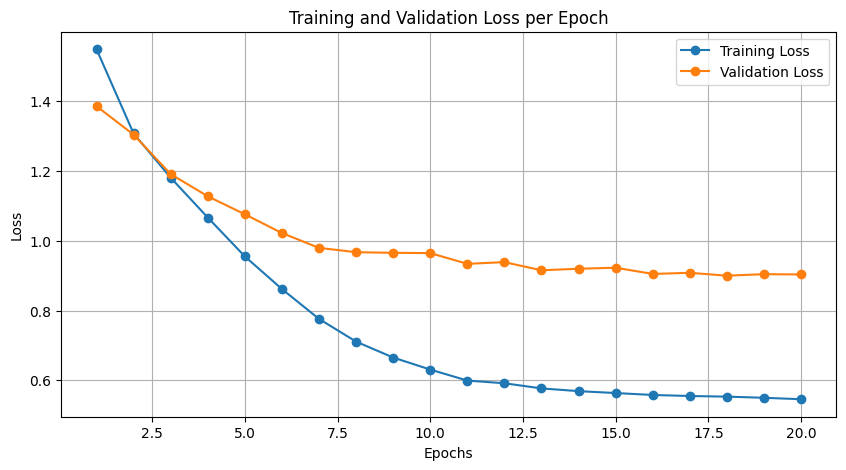

Final Validation Loss: 0.9035
Final Accuracy: 82.32%
Confusion Matrix:
[[239  12  12   0   7   8   3]
 [  8 239  16   1  17   9   5]
 [ 15  19 227   4   6   6   3]
 [  5   1   9 104   0   1   1]
 [  3  24  21   1 175   4   5]
 [  9   8   8   1   2 296   3]
 [  6  10  10   0   3   5  75]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.84      0.85      0.84       281
     Cricket       0.76      0.81      0.79       295
      Tennis       0.75      0.81      0.78       280
    Swimming       0.94      0.86      0.90       121
      Soccer       0.83      0.75      0.79       233
   Wrestling       0.90      0.91      0.90       327
      Karate       0.79      0.69      0.74       109

    accuracy                           0.82      1646
   macro avg       0.83      0.81      0.82      1646
weighted avg       0.83      0.82      0.82      1646



In [59]:
model = SportsCNN_ELU().to(device)
criterion = LabelSmoothingLoss(classes=len(unique_classes), smoothing=0.1, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [60]:
torch.save(model, 'model5_64_20_LS_ELU_Adam_L2.pth')

### <font color='blue'> <b> Setup 7: ELU Activation with Cross Entropy Loss and Batch Normalization. Changing Drop out to 0.3 </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Cross Entropy \
<b>Regularization:</b> Drop-Out(0.3) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>Batch Normalization</b> \
    <b>ELU Activation</b>

In [61]:
class SportsCNN_ELU_BN(nn.Module):
    def __init__(self):
        super(SportsCNN_ELU_BN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn_fc2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 7)

    def forward(self, x):
        x = self.pool(F.elu(self.bn1(self.conv1(x))))
        x = self.pool(F.elu(self.bn2(self.conv2(x))))
        x = self.pool(F.elu(self.bn3(self.conv3(x))))
        x = self.pool(F.elu(self.bn4(self.conv4(x))))
        x = x.view(x.size(0), -1)
        
        x = F.elu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = F.elu(self.bn_fc2(self.fc2(x)))
        x = self.fc3(x)
        return x

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.2064,                 Validation Loss: 1.0183,                 Accuracy: 66.28%,                 Epoch Time: 46.59 seconds
Epoch 2/20,                 Training Loss: 0.7435,                 Validation Loss: 0.8209,                 Accuracy: 72.48%,                 Epoch Time: 44.12 seconds
Epoch 3/20,                 Training Loss: 0.3745,                 Validation Loss: 0.7998,                 Accuracy: 73.75%,                 Epoch Time: 45.41 seconds
Epoch 4/20,                 Training Loss: 0.1392,                 Validation Loss: 0.6596,                 Accuracy: 80.50%,                 Epoch Time: 45.59 seconds
Epoch 5/20,                 Training Loss: 0.0540,                 Validation Loss: 0.6742,                 Accuracy: 80.68%,                 Epoch Time: 45.62 seconds
Epoch 6/20,                 Training Loss: 0.0250,                 Validation Loss: 0.6172,            

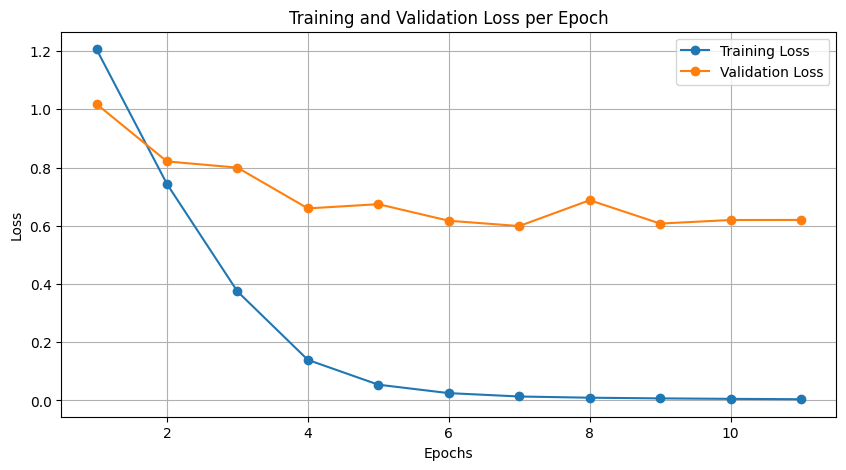

Final Validation Loss: 0.6169
Final Accuracy: 82.20%
Confusion Matrix:
[[235   9  19   2   4   9   3]
 [  8 235  22   3  15   9   3]
 [  7  20 228   5   6   9   5]
 [  2   1   6 109   0   2   1]
 [  5  25  18   0 179   2   4]
 [  8   8  11   1   2 294   3]
 [  6   9   9   3   7   2  73]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.87      0.84      0.85       281
     Cricket       0.77      0.80      0.78       295
      Tennis       0.73      0.81      0.77       280
    Swimming       0.89      0.90      0.89       121
      Soccer       0.84      0.77      0.80       233
   Wrestling       0.90      0.90      0.90       327
      Karate       0.79      0.67      0.73       109

    accuracy                           0.82      1646
   macro avg       0.83      0.81      0.82      1646
weighted avg       0.82      0.82      0.82      1646



In [62]:
model = SportsCNN_ELU_BN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [63]:
torch.save(model, 'model6_64_20_ELU_BN_Adam_L2.pth')

### <font color='blue'> <b> Setup 8: Relu Activation with Label Smoothing Loss and Batch Normalization. Changing Drop out to 0.3 </b>
<font color='darkgreen'> \
<b>Epochs:</b> 20 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Label Smoothing Loss \
<b>Regularization:</b> Drop-Out(0.3) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>Batch Normalization</b> \
    <b>Relu Activation</b>

In [84]:
class SportsCNN_Modified(nn.Module):
    def __init__(self):
        super(SportsCNN_Modified, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout_fc = nn.Dropout(p=0.3)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

Start Training: Epochs: 20
-----------------------------
Epoch 1/20,                 Training Loss: 1.3225,                 Validation Loss: 1.1532,                 Accuracy: 70.11%,                 Epoch Time: 46.94 seconds
Epoch 2/20,                 Training Loss: 0.8506,                 Validation Loss: 1.0013,                 Accuracy: 79.28%,                 Epoch Time: 44.55 seconds
Epoch 3/20,                 Training Loss: 0.6303,                 Validation Loss: 0.9427,                 Accuracy: 81.41%,                 Epoch Time: 43.12 seconds
Epoch 4/20,                 Training Loss: 0.5609,                 Validation Loss: 0.8549,                 Accuracy: 84.81%,                 Epoch Time: 43.70 seconds
Epoch 5/20,                 Training Loss: 0.5451,                 Validation Loss: 0.8526,                 Accuracy: 84.14%,                 Epoch Time: 44.83 seconds
Epoch 6/20,                 Training Loss: 0.5416,                 Validation Loss: 0.8582,            

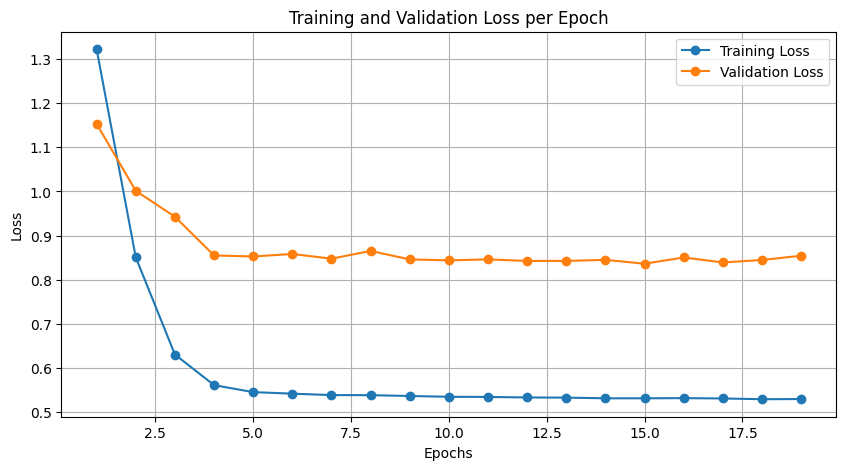

Final Validation Loss: 0.8441
Final Accuracy: 85.60%
Confusion Matrix:
[[248   8  10   0   3   8   4]
 [  8 262  15   1   6   1   2]
 [ 11  23 228   3   2   6   7]
 [  3   1   2 111   0   3   1]
 [  6  21  24   0 176   4   2]
 [  7   5   3   4   1 303   4]
 [  8   7   8   0   3   2  81]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.85      0.88      0.87       281
     Cricket       0.80      0.89      0.84       295
      Tennis       0.79      0.81      0.80       280
    Swimming       0.93      0.92      0.93       121
      Soccer       0.92      0.76      0.83       233
   Wrestling       0.93      0.93      0.93       327
      Karate       0.80      0.74      0.77       109

    accuracy                           0.86      1646
   macro avg       0.86      0.85      0.85      1646
weighted avg       0.86      0.86      0.86      1646



In [85]:
model = SportsCNN_Modified().to(device)
criterion = LabelSmoothingLoss(classes=len(unique_classes), smoothing=0.1, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 20

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [86]:
torch.save(model, 'model7_64_20_Relu_LS_BN_Adam_L2.pth')

### <font color='blue'> <b> Setup 9: Leaky Relu Activation with Cross Entropy Loss and Batch Normalization. Changing Drop out to 0.5 and increasing Epochs </b>
<font color='darkgreen'> \
<b>Epochs:</b> 25 (Increased) \
<b>Batch Size:</b> 64 (Increased) \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Cross Entropy \
<b>Regularization:</b> Drop-Out(0.5) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>Batch Normalization</b> \
    <b>ELU Activation</b>

In [87]:
class SportsCNN_Leaky_Modified(nn.Module):
    def __init__(self):
        super(SportsCNN_Leaky_Modified, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout_fc = nn.Dropout(p=0.5)
        
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 7)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        
        x = self.pool(F.leaky_relu(self.conv2(x), negative_slope=0.01))
        
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01))
        
        x = self.pool(F.leaky_relu(self.conv4(x), negative_slope=0.01))
        
        x = x.view(x.size(0), -1)
        
        x = F.leaky_relu(self.bn_fc1(self.fc1(x)), negative_slope=0.01)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x


Start Training: Epochs: 25
-----------------------------
Epoch 1/25,                 Training Loss: 1.1100,                 Validation Loss: 0.9114,                 Accuracy: 66.10%,                 Epoch Time: 46.70 seconds
Epoch 2/25,                 Training Loss: 0.5286,                 Validation Loss: 0.6870,                 Accuracy: 77.40%,                 Epoch Time: 43.78 seconds
Epoch 3/25,                 Training Loss: 0.2392,                 Validation Loss: 0.5099,                 Accuracy: 83.96%,                 Epoch Time: 44.08 seconds
Epoch 4/25,                 Training Loss: 0.1067,                 Validation Loss: 0.4744,                 Accuracy: 84.81%,                 Epoch Time: 43.42 seconds
Epoch 5/25,                 Training Loss: 0.0456,                 Validation Loss: 0.4315,                 Accuracy: 85.84%,                 Epoch Time: 44.11 seconds
Epoch 6/25,                 Training Loss: 0.0270,                 Validation Loss: 0.4343,            

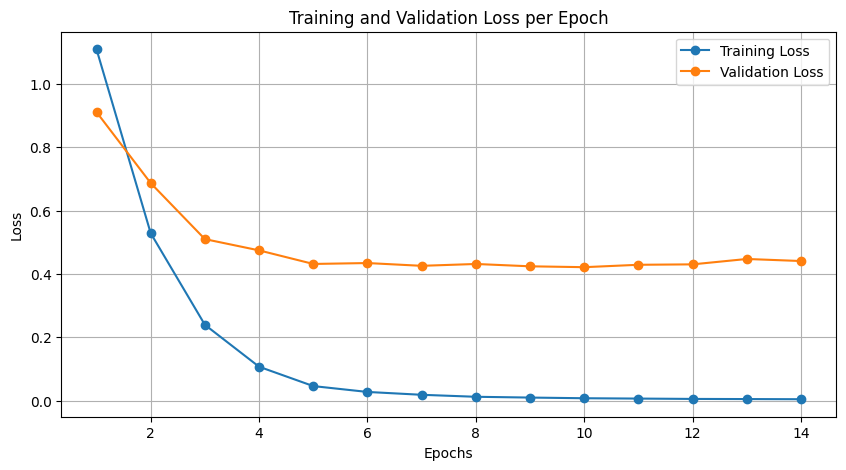

Final Validation Loss: 0.4443
Final Accuracy: 86.51%
Confusion Matrix:
[[241  10  16   0   7   6   1]
 [  0 270   9   1  10   3   2]
 [ 10  20 228   4   9   5   4]
 [  2   2   3 111   0   2   1]
 [  1  20  18   0 184   5   5]
 [  5   6   3   3   2 304   4]
 [  3   9   4   0   5   2  86]]
Classification Report:
              precision    recall  f1-score   support

   Badminton       0.92      0.86      0.89       281
     Cricket       0.80      0.92      0.85       295
      Tennis       0.81      0.81      0.81       280
    Swimming       0.93      0.92      0.93       121
      Soccer       0.85      0.79      0.82       233
   Wrestling       0.93      0.93      0.93       327
      Karate       0.83      0.79      0.81       109

    accuracy                           0.87      1646
   macro avg       0.87      0.86      0.86      1646
weighted avg       0.87      0.87      0.87      1646



In [88]:
model = SportsCNN_Leaky_Modified().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 25

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [89]:
torch.save(model, 'model8_64_20_LRelu_CE_BN_Adam_L2.pth')

### <font color='blue'> Comparing the metrics for all models. We see that the best performing models are Setup 5, Setup 8 and Setup 9.
<font color='green'>- We see the Setup 9 shows the best metrics with lowest loss and lowest training time. However, we see the model significanlty overfits which will degrage the models performance on Unseen Data. \
<font color='green'>- Another model with good performance is Setup 8 which is again having high accuracy. However, its also significantly overfitting which can cause degradation of peformance. \
<font color='green'>- The most balanced model is Setup 5, which shows a consistent trend for decreasing losses for both training and validation. Overall Accuracy is high, however, the losses might be a bit higher as compared the other models. However, since it does not overfit, it generalizes well between training and unseen data.
    
<font color='green'><b>So Setup 5 is our best model and we will use the same to perform another round of evaluation with higher set of epochs and then plot the F1 Scores.

<table>
  <tr>
    <th>Model Config</th>
    <th>Validation Loss</th>
    <th>Accuracy</th>
    <th>Total Training Time</th>
  <tr>
    <td><b>Setup 1</td>
    <td>0.5952</td>
    <td>81.53%</td>
    <td>459.87 seconds</td>    
  </tr>
   <tr>
    <td><b>Setup 2</td>
    <td>0.7080</td>
    <td>83.84%</td>
    <td>860.59 seconds</td>    
  </tr>
   <tr>
    <td><b>Setup 3</td>
    <td>0.8651</td>
    <td>72.90%</td>
    <td>920.09 seconds</td>    
  </tr>
     <tr>
    <td><b>Setup 4</td>
    <td>0.4223</td>
    <td>83.66%</td>
    <td>914.13 seconds</td>    
  </tr>
     <tr>
    <td><font color='blue'><b>Setup 5</td>
    <td><font color='blue'>0.8572</td>
    <td><font color='blue'>85.91%</td>
    <td><font color='blue'>946.14 seconds</td>    
  </tr>
  <tr>
    <td><b>Setup 6</td>
    <td>0.9035</td>
    <td>82.32%</td>
    <td>912.90 seconds</td>    
  </tr>
  <tr>
    <td><b>Setup 7</td>
    <td>0.6169</td>
    <td>82.20%</td>
    <td>579.49 seconds</td>    
  </tr>
  <tr>
    <td><b>Setup 8</td>
    <td>0.8441</td>
    <td>85.60%</td>
    <td>890.34 seconds</td>    
  </tr>
    <tr>
    <td><font color='red'><b>Setup 9</td>
    <td><font color='red'><b>0.4443</td>
    <td><font color='red'><b>86.51%</td>
    <td><font color='red'><b>660.88 seconds</td>    
  </tr>
    </table>

<table>
    <tr>
        <th>Setup 5</th>
        <th>Setup 8</th>
        <th>Setup 9</th>
    </tr>
    <tr>
        <td>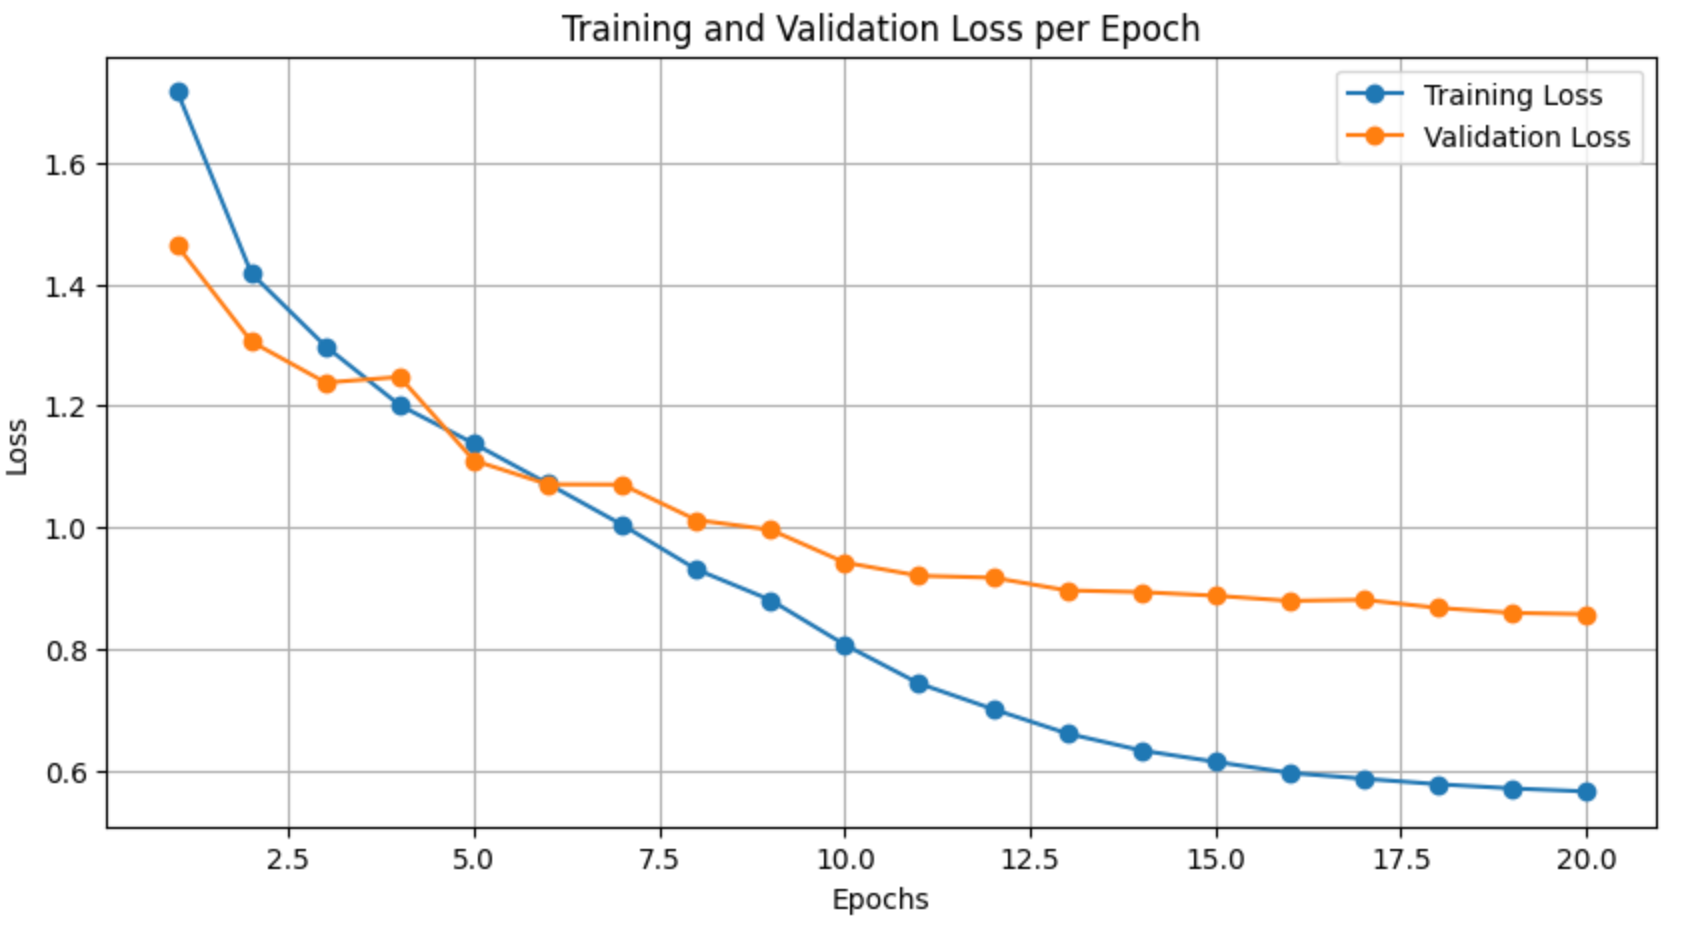</td>
        <td>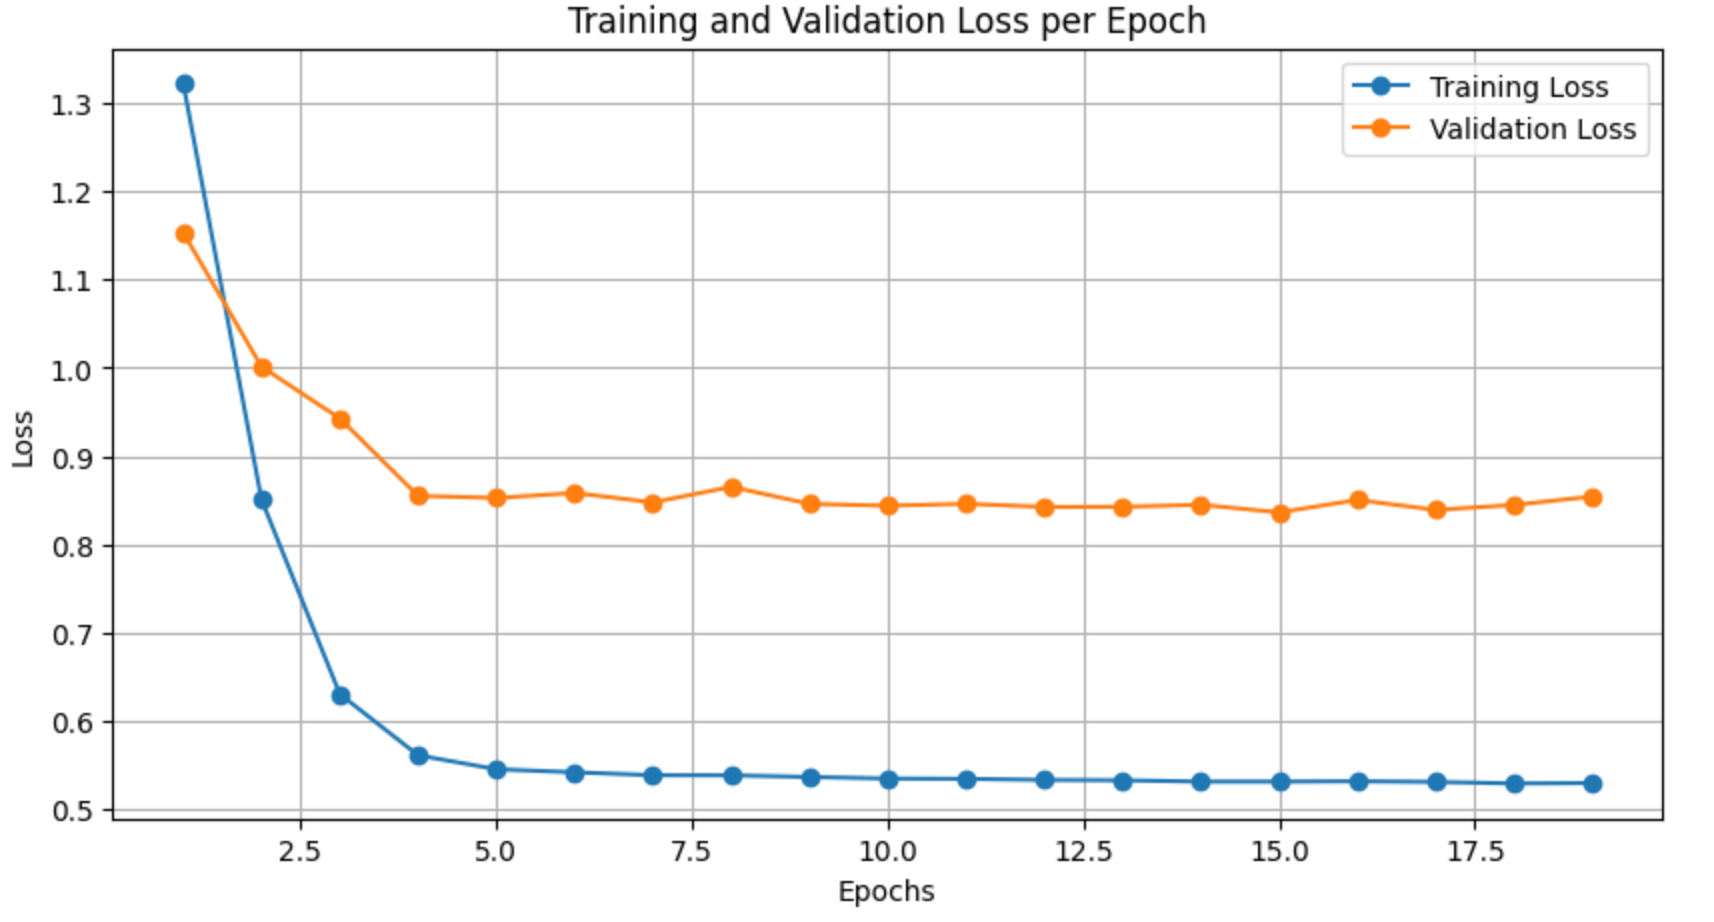</td>
        <td>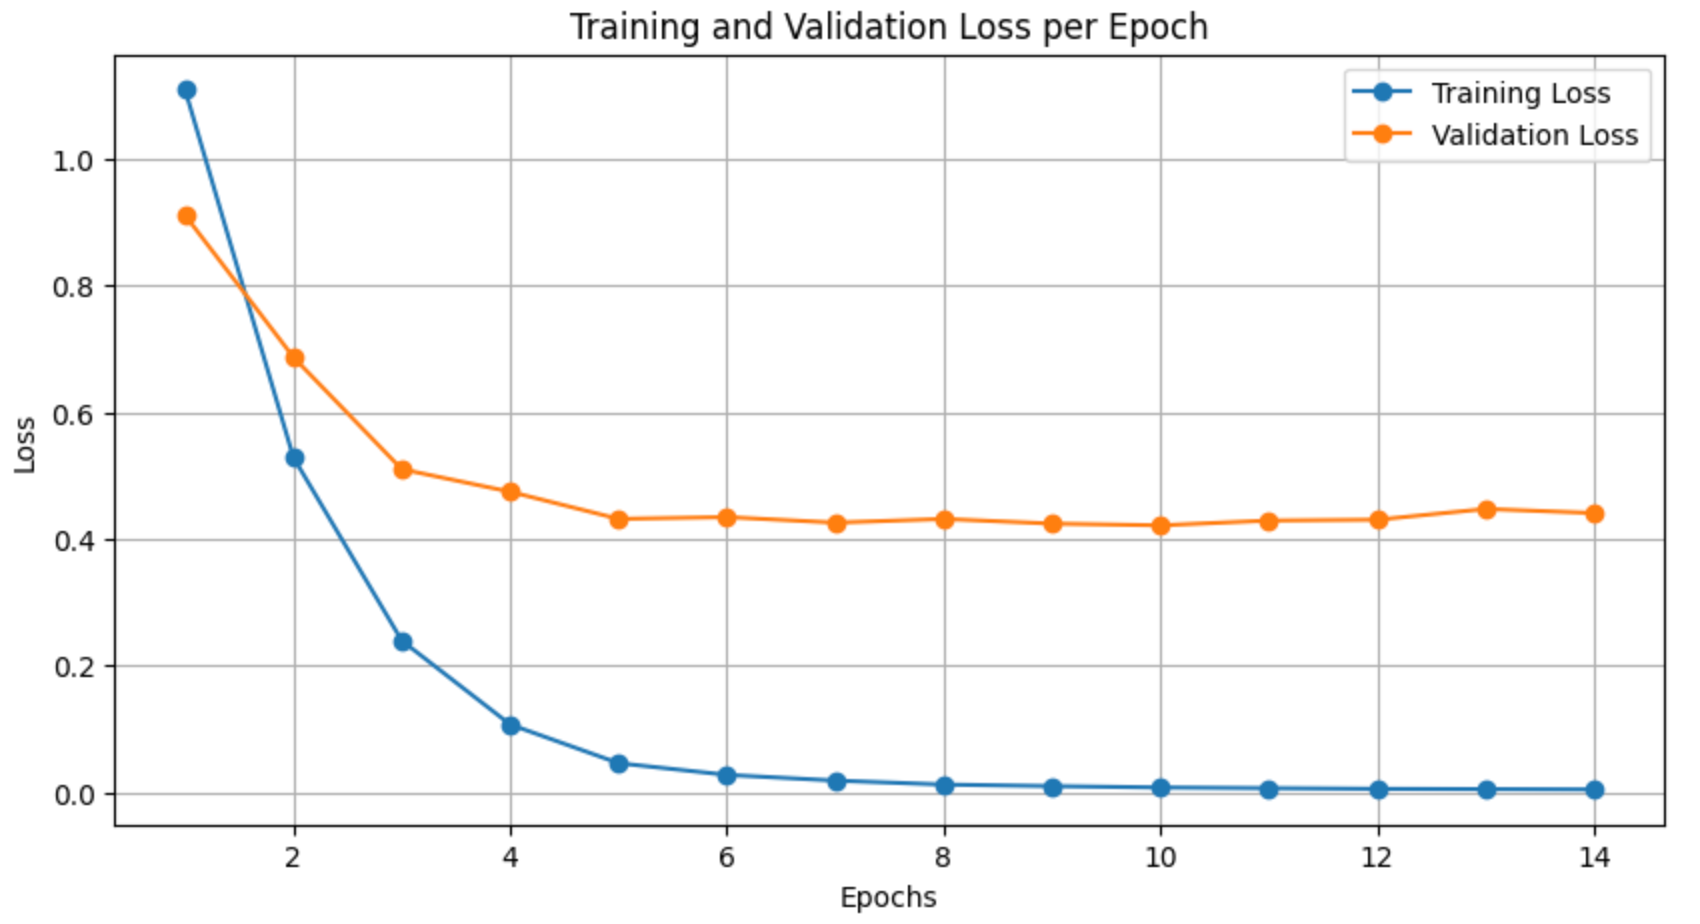</td>
    </tr>
</table>

### <font color='blue'> <b> Setup 10: Using SportsCNN_Leaky from Setup 5 as the model configuration with higher epochs. Introducing a scheduler to reduce learning rate dynamically.</b>
<font color='darkgreen'> \
<b>Epochs:</b> 30 (Increased) \
<b>Batch Size:</b> 64 \
<b>Optimizer:</b> Adam \
<b>Loss Function:</b> Label Smoothing Loss \
<b>Regularization:</b> Drop-Out(0.3) & Weight Decay \
<b>Early-stopping criteria</b> \
    <b>Batch Normalization</b> \
    <b>ELU Activation</b> \
    <b> Scheduler: </b> ReduceLROnPlateau with a patience of 5 and factor of 0.1

<font color='blue'> Updating the Evaluate and Train Model functions to calculate accuracy for both train and validate for Plotting Later

In [33]:
def evaluate_model(model, data_loader, device, class_names, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    avg_val_loss = running_val_loss / len(data_loader)

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    
    f1_score = report['weighted avg']['f1-score']
    return avg_val_loss, accuracy, f1_score, cm, report

In [34]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5):
    
    print(f"Start Training: Epochs: {num_epochs}")
    print('-----------------------------')
    num_epochs = num_epochs
    train_losses = [] 
    val_losses = []
    stopping_epoch = 0
    best_val_loss = float('inf')
    patience_counter = 0
    start_time = time.time()
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        average_loss = running_loss / len(train_loader)
        train_losses.append(average_loss)
        
        train_loss, train_accuracy, train_f1, _, _ = evaluate_model(model, train_loader, device, unique_classes, criterion)
        train_f1_scores.append(train_f1)

        val_loss, accuracy, val_f1, cm, report = evaluate_model(model, val_loader, device, unique_classes, criterion)
        val_losses.append(val_loss)
        val_f1_scores.append(val_f1)
        
        scheduler.step(val_loss)
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                stopping_epoch = epoch
                break
        
        print(f'Epoch {epoch+1}/{num_epochs}, \
                Training Loss: {average_loss:.4f}, \
                Training F1 Score: {train_f1:.4f}, \
                Validation Loss: {val_loss:.4f}, \
                Accuracy: {accuracy * 100:.2f}%, \
                Validation F1 Score: {val_f1:.4f}, \
                Epoch Time: {epoch_duration:.2f} seconds')
    
    total_training_time = time.time() - start_time
    print(f'Total Training Time: {total_training_time:.2f} seconds')
    
    print('-----------------------------')  
    print('End Training')
    return train_losses, val_losses, train_f1_scores, val_f1_scores, stopping_epoch

In [35]:
def plot_f1_epochs(train_f1_scores, val_f1_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, marker='o', color='blue', label='Train F1 Score')
    plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, marker='o', color='orange', label='Val F1 Score')
    plt.title('F1 Scores vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.xticks(range(1, len(val_f1_scores) + 1))
    plt.grid()
    plt.legend()
    plt.show()

In [32]:
def train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience):
    train_losses, val_losses, train_f1_scores, val_f1_scores, stopping_epoch = train_model(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)
    if stopping_epoch != 0:
        num_epochs = stopping_epoch
    plot_epoch_losses(num_epochs, train_losses[:num_epochs], val_losses[:num_epochs])
    plot_f1_epochs(train_f1_scores[:num_epochs], val_f1_scores[:num_epochs])
    final_val_loss, final_accuracy, final_val_f1_score, final_cm, final_report = evaluate_model(model, val_loader, device, unique_classes, criterion)
    print("===============================================")
    print(f'Final Validation Loss: {final_val_loss:.4f}')
    print(f'Final Accuracy: {final_accuracy * 100:.2f}%')
    print("Confusion Matrix:")
    print(final_cm)
    print("Classification Report:")
    print(final_report)

Start Training: Epochs: 30
-----------------------------


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30,                 Training Loss: 1.7447,                 Training F1 Score: 0.4712,                 Validation Loss: 1.4939,                 Accuracy: 51.34%,                 Validation F1 Score: 0.4856,                 Epoch Time: 78.40 seconds
Epoch 2/30,                 Training Loss: 1.4550,                 Training F1 Score: 0.5989,                 Validation Loss: 1.3294,                 Accuracy: 59.72%,                 Validation F1 Score: 0.5898,                 Epoch Time: 80.77 seconds
Epoch 3/30,                 Training Loss: 1.3160,                 Training F1 Score: 0.6467,                 Validation Loss: 1.2529,                 Accuracy: 62.64%,                 Validation F1 Score: 0.6221,                 Epoch Time: 79.10 seconds
Epoch 4/30,                 Training Loss: 1.2097,                 Training F1 Score: 0.7164,                 Validation Loss: 1.1799,                 Accuracy: 68.10%,                 Validation F1 Score: 0.6795,                 Ep

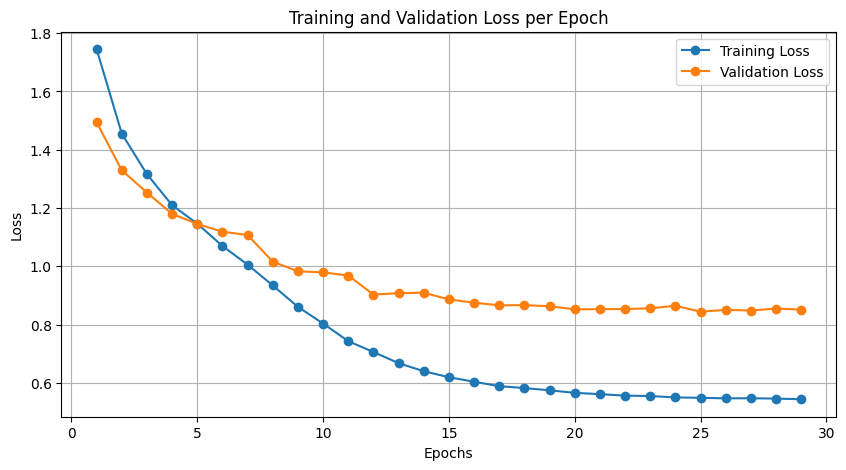

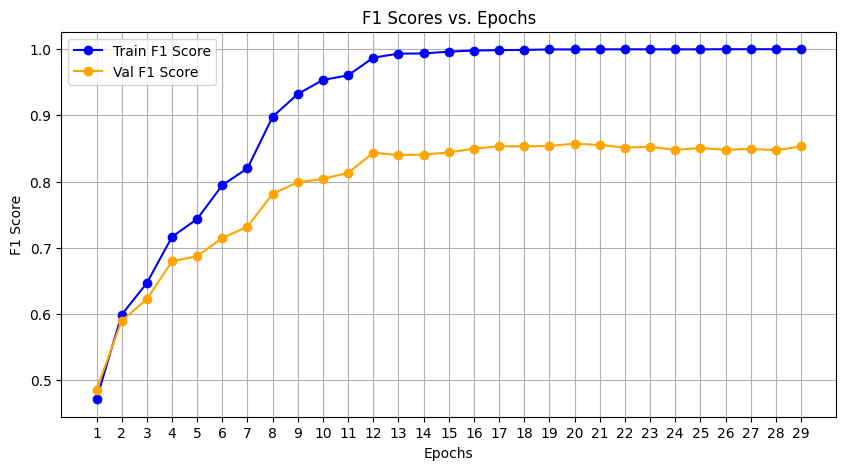

Final Validation Loss: 0.8573
Final Accuracy: 84.99%
Confusion Matrix:
[[230  11  14   2   2  11   5]
 [  7 261   7   0  14   3   4]
 [ 12  28 216   2   9   5   4]
 [  3   1   6 112   0   2   0]
 [  8  22  12   0 217   0   2]
 [  8   5   6   2   2 284   1]
 [  2  11   5   2   2   5  79]]
Classification Report:
{'Badminton': {'precision': 0.8518518518518519, 'recall': 0.8363636363636363, 'f1-score': 0.8440366972477065, 'support': 275}, 'Cricket': {'precision': 0.7699115044247787, 'recall': 0.8817567567567568, 'f1-score': 0.8220472440944883, 'support': 296}, 'Tennis': {'precision': 0.8120300751879699, 'recall': 0.782608695652174, 'f1-score': 0.7970479704797048, 'support': 276}, 'Swimming': {'precision': 0.9333333333333333, 'recall': 0.9032258064516129, 'f1-score': 0.9180327868852459, 'support': 124}, 'Soccer': {'precision': 0.8821138211382114, 'recall': 0.8314176245210728, 'f1-score': 0.8560157790927021, 'support': 261}, 'Wrestling': {'precision': 0.9161290322580645, 'recall': 0.92207792

In [36]:
model = SportsCNN_Leaky().to(device)
criterion = LabelSmoothingLoss(classes=len(unique_classes), smoothing=0.1, reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
num_epochs = 30

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

train_loop(model, train_loader, val_loader, num_epochs, criterion, unique_classes, device, patience=5)

In [37]:
torch.save(model, 'FinalModel_64_40_LRelu_LS_Schd_Adam_L2-1.pth')

## <font color='blue'> Using the best Model on the Test Dataset

<font color='blue'> Calculating the number of trainable parameters

In [38]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [39]:
num_params = count_parameters(model)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 26212167


In [40]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.img_names[idx]

In [41]:
test_dataset = TestDataset(img_dir=test_img_dir, transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [42]:
def imshow(img, title=None):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)

def plot_images_with_predictions(model, test_loader, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))

    with torch.no_grad():
        for images, img_names in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                imshow(images.cpu().data[i], title=f'{img_names[i]}: {class_names[preds[i]]}')

                if images_so_far == num_images:
                    plt.show()
                    return

<font color='blue'> Plotting Images with transformations from Test Dataset with Predictions

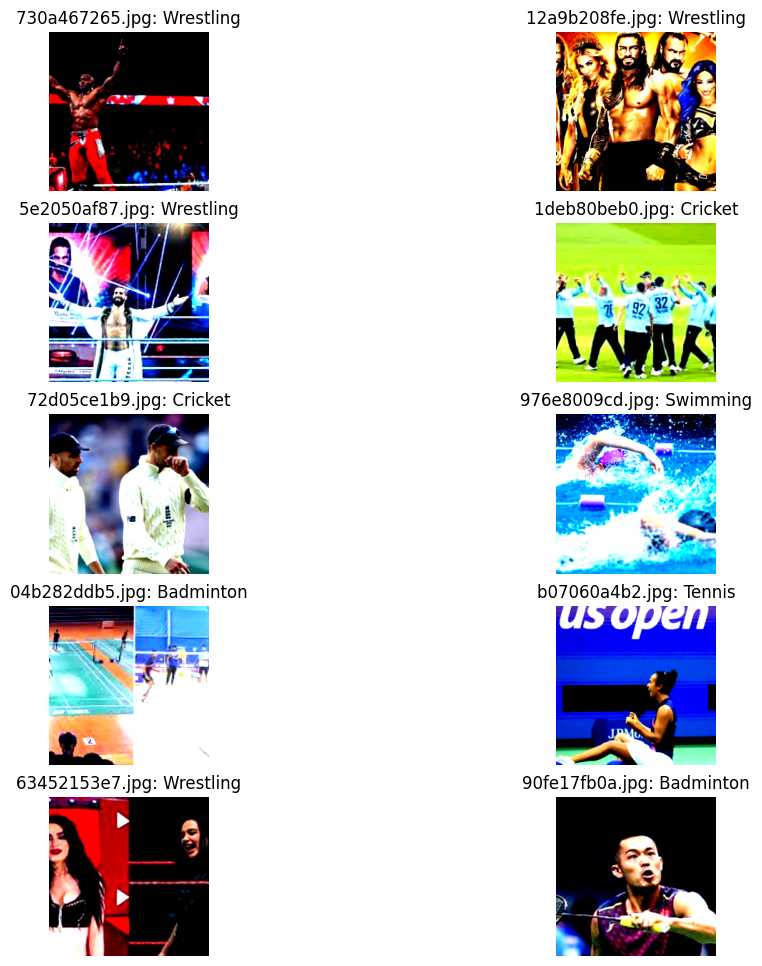

In [43]:
plot_images_with_predictions(model, test_loader, device, unique_classes, num_images=10)

In [44]:
def imshow_no_transform(img_path, title=None):
    img = Image.open(img_path)
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def plot_original_images_with_predictions(model, test_dir, device, class_names, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    with torch.no_grad():
        for img_name in os.listdir(test_dir):
            img_path = os.path.join(test_dir, img_name)
            image = Image.open(img_path)
            
            input_image = transform(image).unsqueeze(0).to(device)

            outputs = model(input_image)
            _, preds = torch.max(outputs, 1)

            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            imshow_no_transform(img_path, title=f'{img_name}: {class_names[preds]}')

            if images_so_far == num_images:
                plt.show()
                return

<font color='blue'> Plotting Images without transformations from Test Dataset with Predictions

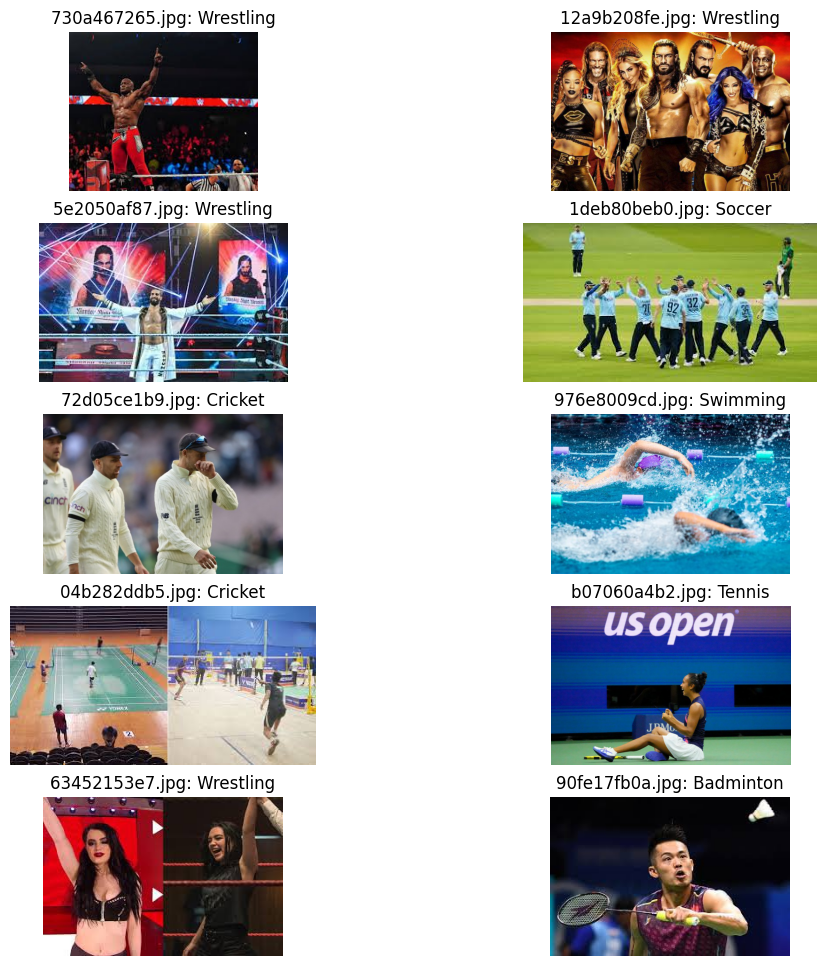

In [45]:
plot_original_images_with_predictions(model, test_img_dir, device, unique_classes, num_images=10)

### <font color='purple'> Thank You